# Model 2: LightGBM (Gradient Boosting)
## Testing across all preprocessing strategies

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score, average_precision_score, recall_score,
    precision_recall_curve, roc_curve, classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

## 1. Load Preprocessed Data

In [2]:
strategies = [
    'strategy1',
    'strategy2a_knn',
    'strategy2b_mice',
    'strategy3_domain'
]

strategy_names = {
    'strategy1': 'Simple (Median/Mode)',
    'strategy2a_knn': 'KNN Imputation',
    'strategy2b_mice': 'MICE Imputation',
    'strategy3_domain': 'Domain-Informed'
}

print("Loading preprocessed datasets for LightGBM...")

Loading preprocessed datasets for LightGBM...


## 2. Train LightGBM on Each Strategy

In [3]:
models = {}
predictions = {}

# LightGBM hyperparameters
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,
    'min_child_samples': 20,
    'random_state': RANDOM_STATE,
    'verbose': -1,
    'is_unbalance': True  # Handle class imbalance
}

for strategy in strategies:
    print(f"\n{'='*70}")
    print(f"Training LightGBM - {strategy_names[strategy]}")
    print(f"{'='*70}")
    
    # Load data
    X_train = pd.read_csv(f'preprocessed_data/{strategy}_X_train.csv')
    X_test = pd.read_csv(f'preprocessed_data/{strategy}_X_test.csv')
    
    if 'strategy2' in strategy:
        y_train = pd.read_csv('preprocessed_data/strategy2_y_train.csv')['undetectable']
        y_test = pd.read_csv('preprocessed_data/strategy2_y_test.csv')['undetectable']
    else:
        y_train = pd.read_csv(f'preprocessed_data/{strategy}_y_train.csv')['undetectable']
        y_test = pd.read_csv(f'preprocessed_data/{strategy}_y_test.csv')['undetectable']
    
    print(f"Training shape: {X_train.shape}")
    print(f"Test shape: {X_test.shape}")
    
    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    # Train model
    lgb_model = lgb.train(
        lgb_params,
        train_data,
        num_boost_round=500,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
    )
    
    # Predictions
    y_pred_proba = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Store results
    models[strategy] = lgb_model
    predictions[strategy] = {
        'y_test': y_test,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"Best iteration: {lgb_model.best_iteration}")
    print(f"Model trained successfully!")

print(f"\nAll LightGBM models trained!")


Training LightGBM - Simple (Median/Mode)
Training shape: (26408, 32)
Test shape: (6603, 32)
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[62]	valid_0's auc: 1
Best iteration: 62
Model trained successfully!

Training LightGBM - KNN Imputation
Training shape: (26408, 32)
Test shape: (6603, 32)
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[3]	valid_0's auc: 0.999046
Best iteration: 3
Model trained successfully!

Training LightGBM - MICE Imputation
Training shape: (26408, 32)
Test shape: (6603, 32)
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[68]	valid_0's auc: 1
Best iteration: 68
Model trained successfully!

Training LightGBM - Domain-Informed
Training shape: (26408, 43)
Test shape: (6603, 43)
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[2]	valid_0's auc: 1
Best iteration: 2
Model trained successfully!

All LightGBM models trained!


## 3. Evaluate Models - AUROC, PR AUC, Recall

In [4]:
evaluation_results = []

for strategy in strategies:
    y_test = predictions[strategy]['y_test']
    y_pred = predictions[strategy]['y_pred']
    y_pred_proba = predictions[strategy]['y_pred_proba']
    
    # Calculate metrics
    auroc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)
    
    # Calculate recall at specific thresholds
    thresholds = [0.3, 0.5, 0.7]
    recalls_at_thresholds = {}
    for thresh in thresholds:
        y_pred_thresh = (y_pred_proba >= thresh).astype(int)
        recalls_at_thresholds[thresh] = recall_score(y_test, y_pred_thresh)
    
    evaluation_results.append({
        'Strategy': strategy_names[strategy],
        'AUROC': auroc,
        'PR AUC': pr_auc,
        'Recall (default)': recall,
        'Recall @0.3': recalls_at_thresholds[0.3],
        'Recall @0.5': recalls_at_thresholds[0.5],
        'Recall @0.7': recalls_at_thresholds[0.7]
    })

results_df = pd.DataFrame(evaluation_results)
print("\n" + "="*90)
print("LIGHTGBM - EVALUATION RESULTS")
print("="*90)
print(results_df.to_string(index=False))
print("="*90)


LIGHTGBM - EVALUATION RESULTS
            Strategy    AUROC   PR AUC  Recall (default)  Recall @0.3  Recall @0.5  Recall @0.7
Simple (Median/Mode) 1.000000 1.000000               1.0          1.0          1.0          1.0
      KNN Imputation 0.999046 0.996889               0.0          1.0          0.0          0.0
     MICE Imputation 1.000000 1.000000               1.0          1.0          1.0          1.0
     Domain-Informed 1.000000 1.000000               0.0          1.0          0.0          0.0


## 4. Detailed Classification Reports

In [5]:
for strategy in strategies:
    print(f"\n{'='*70}")
    print(f"Classification Report - {strategy_names[strategy]}")
    print(f"{'='*70}")
    
    y_test = predictions[strategy]['y_test']
    y_pred = predictions[strategy]['y_pred']
    
    print(classification_report(y_test, y_pred, 
                                target_names=['Not Suppressed', 'Suppressed']))
    
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"  [TN={cm[0,0]}, FP={cm[0,1]}]")
    print(f"  [FN={cm[1,0]}, TP={cm[1,1]}]")


Classification Report - Simple (Median/Mode)
                precision    recall  f1-score   support

Not Suppressed       1.00      1.00      1.00      4390
    Suppressed       1.00      1.00      1.00      2213

      accuracy                           1.00      6603
     macro avg       1.00      1.00      1.00      6603
  weighted avg       1.00      1.00      1.00      6603


Confusion Matrix:
[[4385    5]
 [   0 2213]]
  [TN=4385, FP=5]
  [FN=0, TP=2213]

Classification Report - KNN Imputation
                precision    recall  f1-score   support

Not Suppressed       0.66      1.00      0.80      4390
    Suppressed       0.00      0.00      0.00      2213

      accuracy                           0.66      6603
     macro avg       0.33      0.50      0.40      6603
  weighted avg       0.44      0.66      0.53      6603


Confusion Matrix:
[[4390    0]
 [2213    0]]
  [TN=4390, FP=0]
  [FN=2213, TP=0]

Classification Report - MICE Imputation
                precision    re

## 5. Visualization - ROC Curves

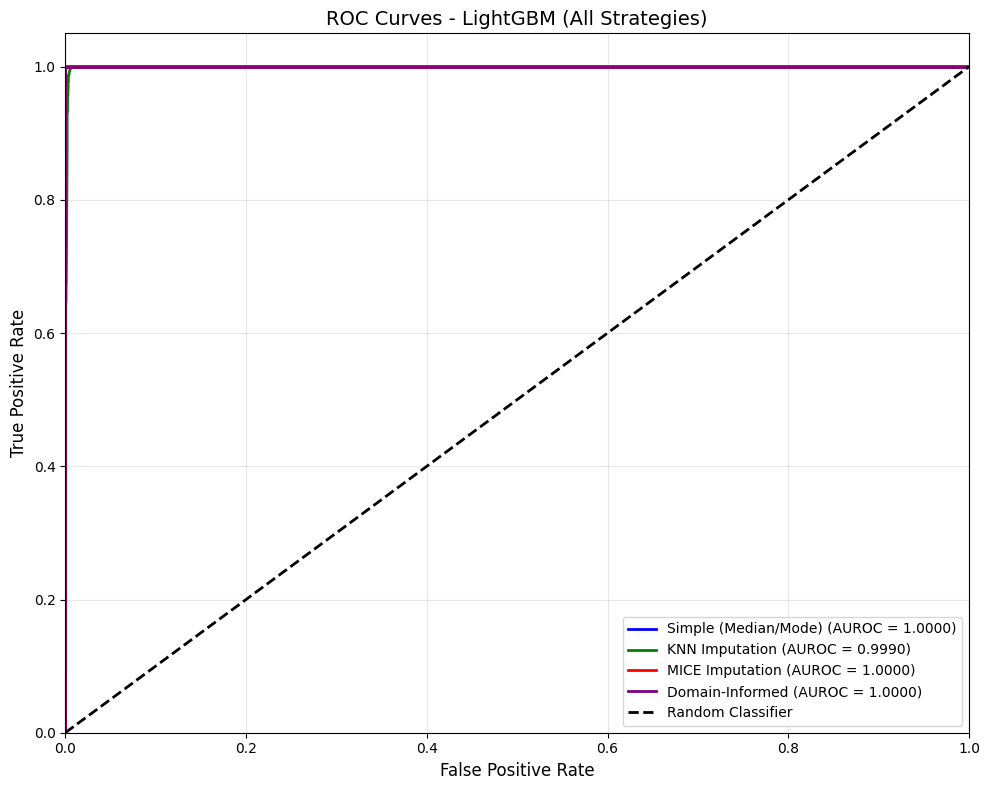

In [6]:
plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red', 'purple']

for idx, strategy in enumerate(strategies):
    y_test = predictions[strategy]['y_test']
    y_pred_proba = predictions[strategy]['y_pred_proba']
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auroc = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot(fpr, tpr, color=colors[idx], lw=2,
             label=f'{strategy_names[strategy]} (AUROC = {auroc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - LightGBM (All Strategies)', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('lightgbm_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Visualization - Precision-Recall Curves

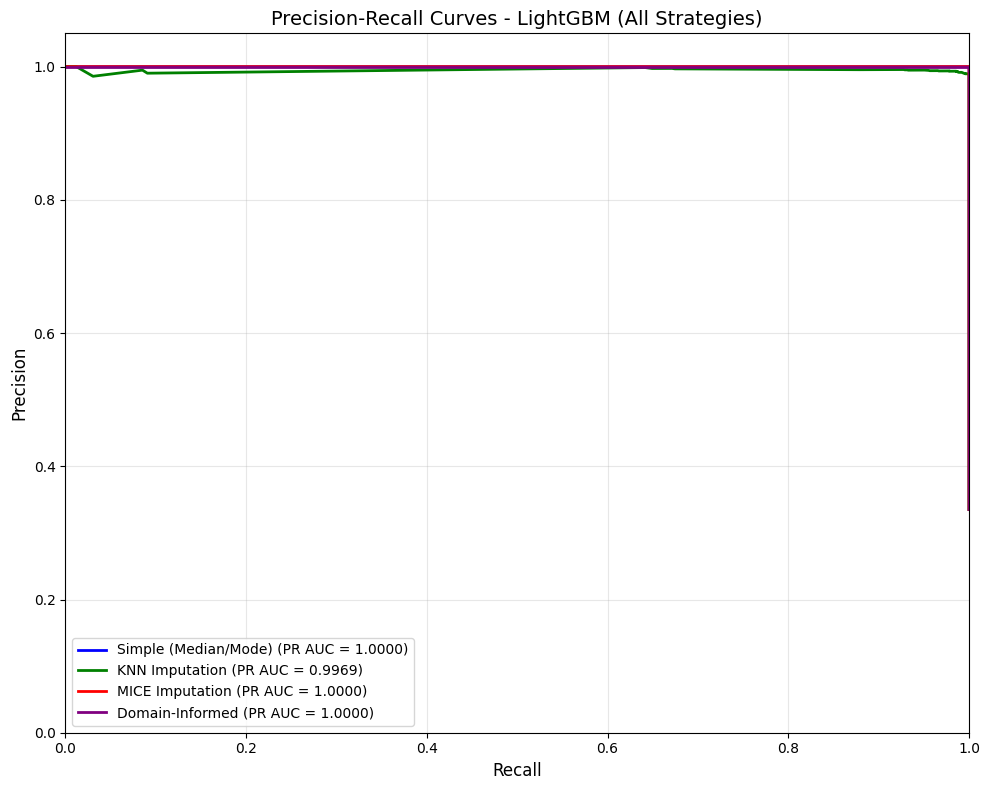

In [7]:
plt.figure(figsize=(10, 8))

for idx, strategy in enumerate(strategies):
    y_test = predictions[strategy]['y_test']
    y_pred_proba = predictions[strategy]['y_pred_proba']
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    plt.plot(recall, precision, color=colors[idx], lw=2,
             label=f'{strategy_names[strategy]} (PR AUC = {pr_auc:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - LightGBM (All Strategies)', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('lightgbm_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Feature Importance

Best performing strategy: Simple (Median/Mode)

Top 20 Most Important Features:
      Feature          Gain  Split
10      logvl  3.221102e+05    225
1       visit  2.122525e+04    300
17      CD4_8  7.543547e+03    393
5        nrti  7.384690e+03     95
11    sqrtcd4  3.261766e+03    176
7          pi  2.675301e+03    136
8    hemoglob  2.204819e+03     39
13   duration  2.120210e+03    213
12    sqrtcd8  4.571792e+02     78
16        vla  4.400722e+02     21
6       nnrti  3.226473e+02     33
4    ageatvis  1.983460e+02     46
9           n  1.861419e+02     29
22          N  1.347318e+02     39
15       cd8a  3.796182e+01     11
14  durationy  3.336129e+01      7
23       call  1.028460e+01      1
3     anydrug  1.587200e+00      9
2        race  9.094950e-13      1
25  genotype3  0.000000e+00      0


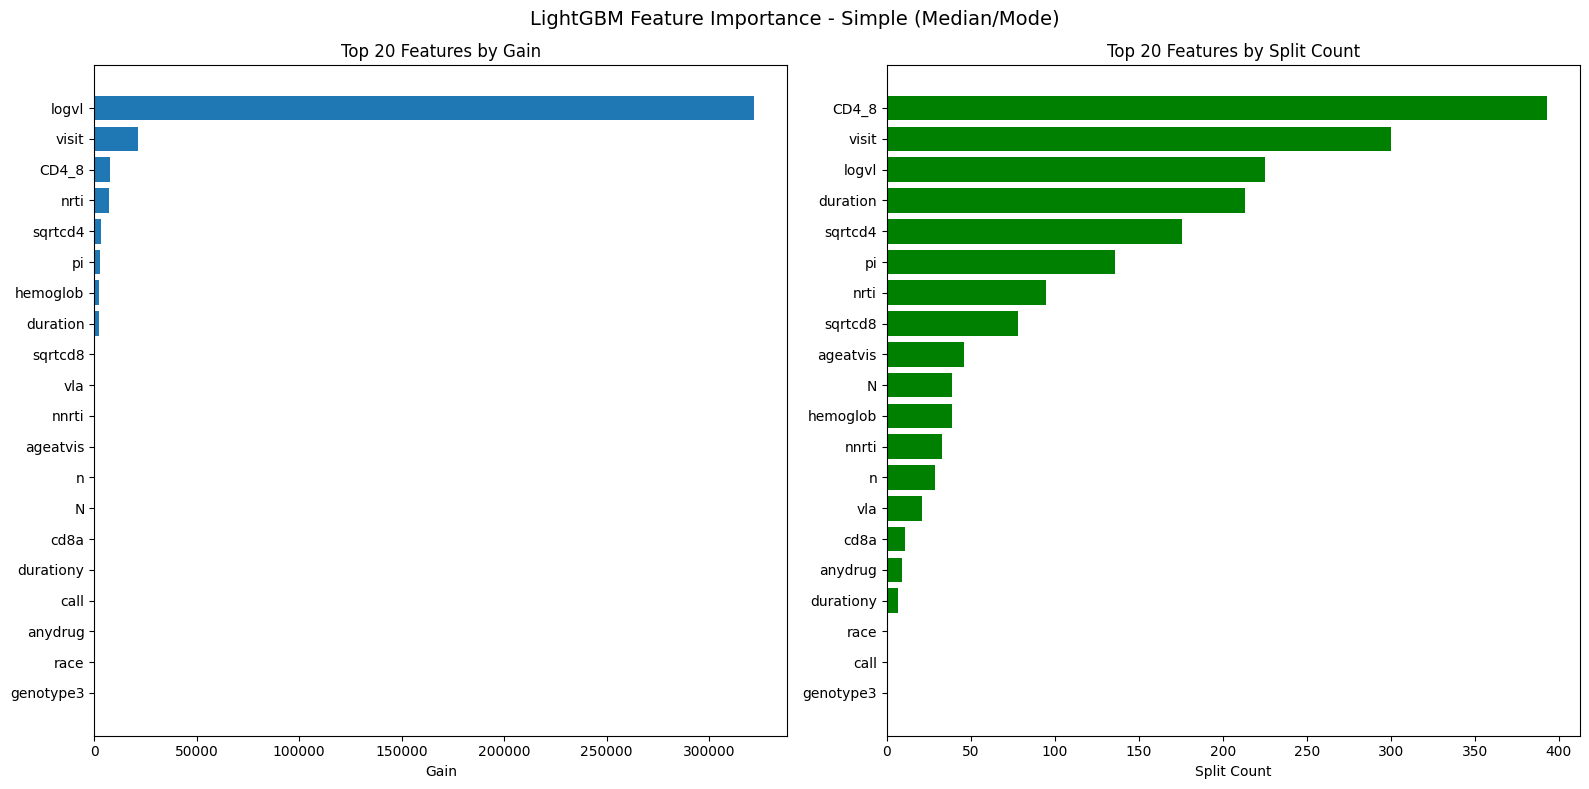

In [8]:
# Find best strategy
best_strategy_idx = results_df['AUROC'].idxmax()
best_strategy = strategies[best_strategy_idx]
best_strategy_name = strategy_names[best_strategy]

print(f"Best performing strategy: {best_strategy_name}")

# Get feature importance
model = models[best_strategy]
X_train = pd.read_csv(f'preprocessed_data/{best_strategy}_X_train.csv')
feature_names = X_train.columns

importance_gain = model.feature_importance(importance_type='gain')
importance_split = model.feature_importance(importance_type='split')

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Gain': importance_gain,
    'Split': importance_split
}).sort_values('Gain', ascending=False)

print(f"\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Gain importance
top_gain = feature_importance.head(20)
axes[0].barh(range(len(top_gain)), top_gain['Gain'])
axes[0].set_yticks(range(len(top_gain)))
axes[0].set_yticklabels(top_gain['Feature'])
axes[0].set_xlabel('Gain')
axes[0].set_title('Top 20 Features by Gain')
axes[0].invert_yaxis()

# Split importance
top_split = feature_importance.sort_values('Split', ascending=False).head(20)
axes[1].barh(range(len(top_split)), top_split['Split'], color='green')
axes[1].set_yticks(range(len(top_split)))
axes[1].set_yticklabels(top_split['Feature'])
axes[1].set_xlabel('Split Count')
axes[1].set_title('Top 20 Features by Split Count')
axes[1].invert_yaxis()

plt.suptitle(f'LightGBM Feature Importance - {best_strategy_name}', fontsize=14)
plt.tight_layout()
plt.savefig('lightgbm_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Learning Curves (for best strategy)

In [9]:
# Plot learning curve from training history
# Note: LightGBM stores validation results during training
print("Learning curves are implicitly captured during training with early stopping")
print(f"Best iteration for {best_strategy_name}: {models[best_strategy].best_iteration}")

Learning curves are implicitly captured during training with early stopping
Best iteration for Simple (Median/Mode): 62


## 9. Save Results

In [10]:
import os
os.makedirs('model_results', exist_ok=True)

# Save evaluation results
results_df.to_csv('model_results/lightgbm_results.csv', index=False)

# Save models
for strategy in strategies:
    models[strategy].save_model(f'model_results/lightgbm_{strategy}.txt')

# Save predictions
with open('model_results/lightgbm_predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

# Save feature importance
feature_importance.to_csv(f'model_results/lightgbm_feature_importance_{best_strategy}.csv', index=False)

print("Results saved to 'model_results/' directory")

Results saved to 'model_results/' directory


## 10. Summary

In [11]:
print("\n" + "="*90)
print("LIGHTGBM - SUMMARY")
print("="*90)

print("\nModel Configuration:")
print("  - Algorithm: LightGBM (Gradient Boosting Decision Trees)")
print("  - Objective: Binary classification")
print("  - Max rounds: 500 with early stopping (50 rounds)")
print("  - Learning rate: 0.05")
print("  - Num leaves: 31")
print("  - Feature fraction: 0.8")
print("  - Bagging fraction: 0.8")
print("  - Class imbalance: Handled")

print("\nPreprocessing Strategies Tested:")
for strategy in strategies:
    print(f"  - {strategy_names[strategy]}")

print("\nBest Strategy:")
print(f"  - {best_strategy_name}")
print(f"  - AUROC: {results_df.loc[best_strategy_idx, 'AUROC']:.4f}")
print(f"  - PR AUC: {results_df.loc[best_strategy_idx, 'PR AUC']:.4f}")
print(f"  - Recall: {results_df.loc[best_strategy_idx, 'Recall (default)']:.4f}")
print(f"  - Best iteration: {models[best_strategy].best_iteration}")

print("\nPerformance Statistics:")
print(f"  - AUROC range: {results_df['AUROC'].min():.4f} - {results_df['AUROC'].max():.4f}")
print(f"  - Average AUROC: {results_df['AUROC'].mean():.4f}")
print(f"  - Average PR AUC: {results_df['PR AUC'].mean():.4f}")
print(f"  - Average Recall: {results_df['Recall (default)'].mean():.4f}")

print("\nKey Advantages of LightGBM:")
print("  - Handles non-linear relationships")
print("  - Automatic feature interaction detection")
print("  - Built-in handling of missing values")
print("  - Fast training with early stopping")
print("  - Feature importance analysis")

print("\n" + "="*90)


LIGHTGBM - SUMMARY

Model Configuration:
  - Algorithm: LightGBM (Gradient Boosting Decision Trees)
  - Objective: Binary classification
  - Max rounds: 500 with early stopping (50 rounds)
  - Learning rate: 0.05
  - Num leaves: 31
  - Feature fraction: 0.8
  - Bagging fraction: 0.8
  - Class imbalance: Handled

Preprocessing Strategies Tested:
  - Simple (Median/Mode)
  - KNN Imputation
  - MICE Imputation
  - Domain-Informed

Best Strategy:
  - Simple (Median/Mode)
  - AUROC: 1.0000
  - PR AUC: 1.0000
  - Recall: 1.0000
  - Best iteration: 62

Performance Statistics:
  - AUROC range: 0.9990 - 1.0000
  - Average AUROC: 0.9998
  - Average PR AUC: 0.9992
  - Average Recall: 0.5000

Key Advantages of LightGBM:
  - Handles non-linear relationships
  - Automatic feature interaction detection
  - Built-in handling of missing values
  - Fast training with early stopping
  - Feature importance analysis

